# Year 2023 Day 03

[--- Day 3: Gear Ratios ---](https://adventofcode.com/2023/day/3)


## Motive

Here, the [Text Mark](https://observablehq.com/plot/marks/text) is put in the spotlight.

Also, an attempt is made to refactor the visualization code in order to get a more flexible API. The main idea is to step-up from raw functions with too many keyword arguments to a lazy-builder pattern, creating an open-ended lazy task graph on which it is easy to add other plotting steps. This can be seen as a layer system, to layer marks on top of each other, while being able to reuse a common stack. This comes handy in situation where we want to compose _orthogonally_ multiple marks together. The concrete example in this notebook will be the "neighborhood" visualization, that can be pasted over different initial raster visualizations (like a base map).

To improve the abstraction, the vocabulary from all cartography APIs could be reused.

## Related puzzles

The Observable Plot visualization library is used.

The [Text Mark](https://observablehq.com/plot/marks/text) is also used in:

- [Notebook 202310](./notebook_problem_202310.html) (_Pipe Maze_) to add values on top of a [Raster Mark](https://observablehq.com/plot/marks/raster)
- [Notebook 202324](./notebook_problem_202324.html) (_Never Tell Me The Odds_) to annotate vectors (the [Link Mark](https://observablehq.com/plot/marks/link)) with a time value


In [1]:
from typing import Any, Callable

import pandas as pd
import xarray as xr
from pyobsplot import Plot

In [2]:
from advent_of_code.y_2023.problem_202303 import AdventOfCodeProblem202303

problem = AdventOfCodeProblem202303()
problem

AdventOfCodeProblem202303(year=2023, day=3)

## Visualization Code


## With Example Input


In [3]:
from advent_of_code.common.common import get_example_inputs_file_contents

example_input = get_example_inputs_file_contents(2023)["test_problem_202303"][
    "EXAMPLE_INPUT"
]
parsed_example_input = xr.DataArray(
    problem.parse_text_input(example_input), dims=("row", "col")
)

In [4]:
from advent_of_code.visualization.observable_plot import ascii_2d_numpy_array_plotter


example_input_plotter = ascii_2d_numpy_array_plotter(
    parsed_example_input,
    obfuscate=False,
    text=True,
    width=300,
    height=300,
)

In [5]:
example_input_plotter.plot()

Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c250d940>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c250da80>


Symbols are defined as being non-numerical and different from the dot character.


In [6]:
def symbols_xda(xda: xr.DataArray) -> xr.DataArray:
    return ((xda != ord(".")) * 1) & ~xda.isin(list(range(ord("1"), ord("9") + 1)))

In [7]:
example_input_symbols_plotter = ascii_2d_numpy_array_plotter(
    symbols_xda(parsed_example_input),
    obfuscate=False,
    text=False,
    scheme="viridis",
    width=300,
    height=300,
)
example_input_symbols_plotter.plot()

Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c25960c0>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c2596020>


We are interested in all numbers in the neighborhood of the symbols. The neighborhood is a 3x3 box with the symbol in its center.


In [8]:
def rect_df(
    symbols_xda: xr.DataArray,
    *,
    offset: float = 0.3,
    x1_target: str = "x1",
    x2_target: str = "x2",
    y1_target: str = "y1",
    y2_target: str = "y2",
) -> pd.DataFrame:
    df = symbols_xda.stack(y=("row", "col")).to_pandas()
    df = df[df == 1]

    rows_1 = [idx[0] - (offset + 0.5) for idx in df.index]
    rows_2 = [idx[0] + (offset + 1.5) for idx in df.index]
    cols_1 = [idx[1] - (offset + 0.5) for idx in df.index]
    cols_2 = [idx[1] + (offset + 1.5) for idx in df.index]

    rect_df = pd.DataFrame.from_records(
        {
            x1_target: cols_1,
            x2_target: cols_2,
            y1_target: rows_1,
            y2_target: rows_2,
        }
    )
    return rect_df

In [9]:
def neighborhood_mark_layer(
    xda: xr.DataArray,
    *,
    color: str = "red",
    stroke_width: int = 2,
) -> Callable[[], list[Any]]:
    def callback() -> list[Any]:
        x1_target = "x1"
        x2_target = "x2"
        y1_target = "y1"
        y2_target = "y2"

        return [
            Plot.rect(  # type:ignore
                rect_df(
                    xda,
                    x1_target=x1_target,
                    x2_target=x2_target,
                    y1_target=y1_target,
                    y2_target=y2_target,
                ),
                {
                    x1_target: "x1",
                    y1_target: "y1",
                    x2_target: "x2",
                    y2_target: "y2",
                    "stroke": color,
                    "strokeWidth": stroke_width,
                },
            ),
        ]

    return callback

In [10]:
example_input_symbols_plotter.copy().stack(
    neighborhood_mark_layer(symbols_xda(parsed_example_input))
).plot()

Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c25962a0>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c2596020>
Layer #2 <function neighborhood_mark_layer.<locals>.callback at 0x7f27c2596520>


In [11]:
example_input_plotter.copy().stack(
    neighborhood_mark_layer(symbols_xda(parsed_example_input))
).plot()

Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c25739c0>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c250da80>
Layer #2 <function neighborhood_mark_layer.<locals>.callback at 0x7f27c2573c40>


In Part 1, the _part numbers_ are all numbers intersecting with the symbols' neighborhoods.


In [12]:
from advent_of_code.y_2023.problem_202303 import find_part_numbers

part_numbers = find_part_numbers(parsed_example_input.values)
part_numbers

[467, 35, 633, 617, 592, 755, 664, 598]

In Part 2, we are only interested by gears, represented by the `*`-symbol, if they are adjacent to exactly two _part numbers_.


In [13]:
from advent_of_code.y_2023.problem_202303 import find_part_numbers_and_gears


gear_part_numbers_tuples = find_part_numbers_and_gears(parsed_example_input.values)
gear_part_numbers_tuples

[(467, 35), (755, 598)]

In [14]:
def gears(puzzle_input: xr.DataArray) -> xr.DataArray:
    return puzzle_input == ord("*")

In [15]:
example_input_plotter.copy().stack(
    neighborhood_mark_layer(gears(parsed_example_input))
).plot()

Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c2573ba0>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c250da80>
Layer #2 <function neighborhood_mark_layer.<locals>.callback at 0x7f27c2573b00>


The top and bottom gears touch exactly two numbers. The middle gear is excluded from the solution as it only touches one number.


## With Actual Input


In [16]:
parsed_actual_input = xr.DataArray(problem.parse_input_text_file(), dims=("row", "col"))
parsed_actual_input

<xarray.DataArray (row: 142, col: 142)> Size: 20kB
array([[46, 46, 46, ..., 46, 46, 46],
       [46, 46, 46, ..., 46, 46, 46],
       [46, 53, 54, ..., 46, 46, 46],
       ...,
       [46, 46, 46, ..., 46, 46, 46],
       [46, 57, 53, ..., 52, 54, 46],
       [46, 46, 46, ..., 46, 46, 46]], dtype=uint8)
Dimensions without coordinates: row, col

In [17]:
plot_width = parsed_actual_input["col"].size * 3

actual_input_plotter = ascii_2d_numpy_array_plotter(
    parsed_actual_input,
    obfuscate=True,
    text=False,
    width=plot_width,
    height=plot_width,
    scheme="viridis",
    aspectRatio=1,
)

Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f28116b3d80>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c26a1f80>



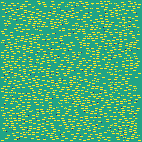

In [18]:
actual_input_plotter.plot()

Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c2595080>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c26a1f80>



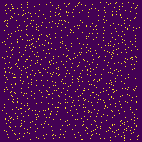

In [19]:
actual_input_plotter.copy(
    raster_xda=symbols_xda(parsed_actual_input),
).plot()

Numbers of interest for part 1:


Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c2534c20>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c26a1f80>
Layer #2 <function neighborhood_mark_layer.<locals>.callback at 0x7f27c25963e0>



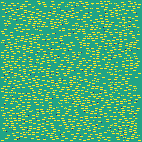

In [20]:
actual_input_plotter.copy().stack(
    neighborhood_mark_layer(symbols_xda(parsed_actual_input))
).plot()

Gear candidates for part 2:


Layer #0 <function ObservablePlotXarrayBuilder.create_raster_background_marks.<locals>.callback at 0x7f27c2535b20>
Layer #1 <function text_mark_producer.<locals>.callback at 0x7f27c26a1f80>
Layer #2 <function neighborhood_mark_layer.<locals>.callback at 0x7f27c2535bc0>



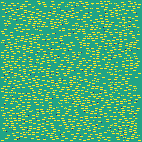

In [21]:
actual_input_plotter.copy().stack(
    neighborhood_mark_layer(gears(parsed_actual_input))
).plot()